In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../geometry') 
from pyMesh import hcubeMesh, visualize2D, plotBC, plotMesh,setAxisLabel

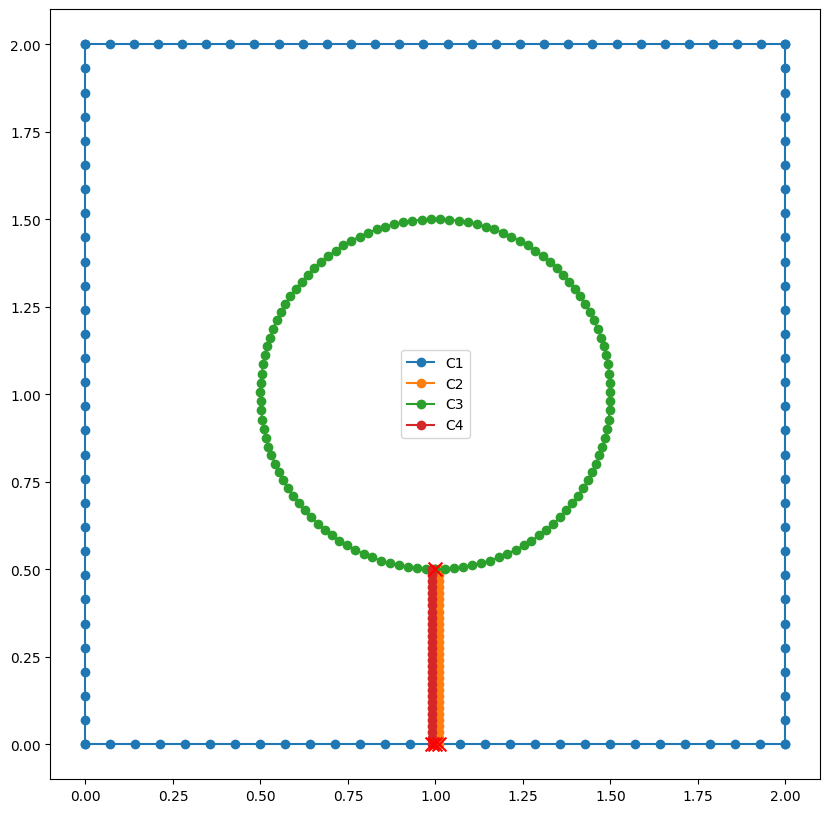

In [2]:
#define geometry

L = 2.0
R = 0.5
O = [1.0, 1.0]

linspace = np.linspace(0, L, 25)
C1_x = np.concatenate((np.linspace(L/2, 0, 15), np.zeros(30), np.linspace(0, L, 30), L*np.ones(30), np.linspace(L, L/2, 15)))
C1_y = np.concatenate((np.zeros(15), np.linspace(0, L, 30), L*np.ones(30), np.linspace(L, 0, 30), np.zeros(15)))
# C1 = np.array([C1_x, C1_y]).T

theta = -np.pi/2
C3_x = R*np.cos(np.linspace(theta, -2*np.pi+theta, 120)) + O[0]
C3_y = R*np.sin(np.linspace(theta, -2*np.pi+theta, 120)) + O[1]
# C2 = np.array([C2_x, C2_y]).T

C2_x = np.ones(30)*L/2
C2_y = np.linspace(0, L/2-R, 30)

C4_x = C2_x
C4_y = C2_y

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.plot(C1_x, C1_y, marker='o', label='C1')
plt.scatter(C1_x[0], C1_y[0], marker='x', color='red', s=100, zorder=10)
plt.plot(C2_x+ 0.01, C2_y, marker='o', label='C2')
plt.scatter(C2_x[0]+0.01, C2_y[0], marker='x', color='red', s=100, zorder=10)
plt.plot(C3_x, C3_y, marker='o', label='C3')
plt.scatter(C3_x[0], C3_y[0], marker='x', color='red', s=100, zorder=10)
plt.plot(C4_x-0.01, C4_y, marker='o', label='C4')
plt.scatter(C4_x[0]-0.01, C4_y[0], marker='x', color='red', s=100, zorder=10)

ax.set_aspect('equal')
plt.legend()



In [3]:
ny=len(C1_x); nx=len(C2_x)
h=0.01

myMesh=hcubeMesh(C1_x, C1_y, C3_x, C3_y, C4_x, C4_y, C2_x, C2_y, 
                h,False,False,
                tolMesh=1e-10,tolJoint=1e-2)
print(C1_y[0],C4_y[0])

====>Check bc nodes!
====>BC nodes pass!
The mesh generation reaches covergence!
0.0 0.0


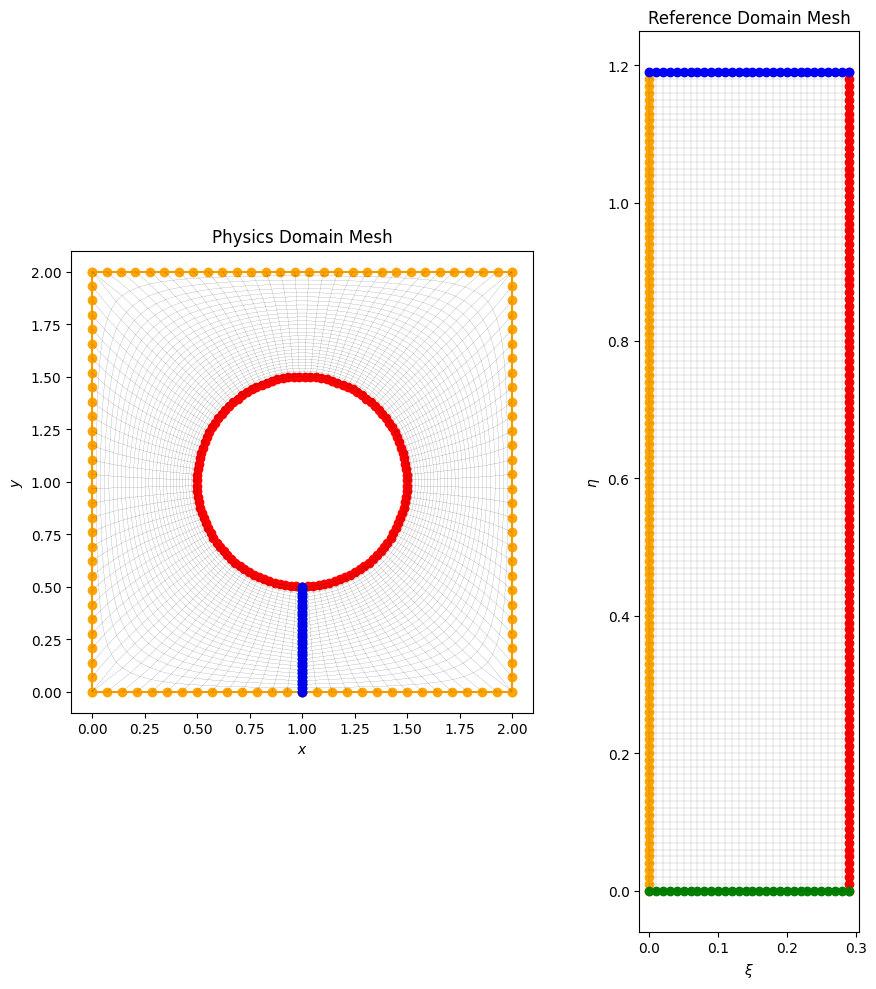

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
plotBC(ax[0],myMesh.x,myMesh.y)
plotMesh(ax[0],myMesh.x,myMesh.y)
setAxisLabel(ax[0],'p')
ax[0].set_aspect('equal')
ax[0].set_title('Physics Domain Mesh')

plotBC(ax[1],myMesh.xi,myMesh.eta)
plotMesh(ax[1],myMesh.xi,myMesh.eta)
setAxisLabel(ax[1],'r')
ax[1].set_aspect('equal')
ax[1].set_title('Reference Domain Mesh')
fig.tight_layout()

In [10]:
#save the mesh
ny=len(C1_x); nx=len(C2_x)
data_path = f"plate_hole_{nx}x{ny}.txt"
np.savetxt(data_path, np.hstack((myMesh.x.reshape(-1, 1), myMesh.y.reshape(-1, 1))), delimiter=' ', fmt='%1.16f')

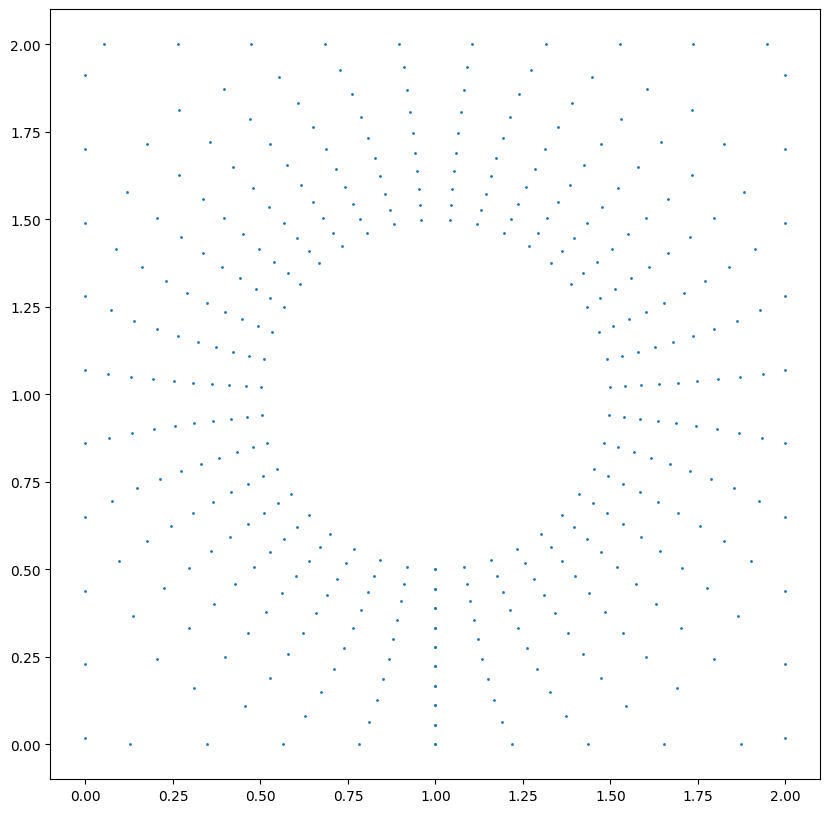

In [12]:
import jax
import jax.numpy as jnp

# Load geometry mapping
nx=30
ny=120
Xp = np.loadtxt(f"plate_hole_{nx}x{ny}.txt")

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def coordMap(x):
    x_pos = x[:, 0]*(nx-1)
    y_pos = x[:, 1]*(ny-1)

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1)
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1)

    return jnp.stack((x_mapped, y_mapped), axis=1)


x_plot = np.linspace(0, 1, 10)
y_plot = np.linspace(0, 1, 40)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot, Y_plot = X_plot.flatten(), Y_plot.flatten()
X_mapped, Y_mapped = coordMap(jax.numpy.stack((X_plot, Y_plot), axis=1)).T

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.scatter(X_mapped, Y_mapped, s=1)
# plt.xlim(0, x_max)
# plt.ylim(0, y_max)
ax.set_aspect('equal')

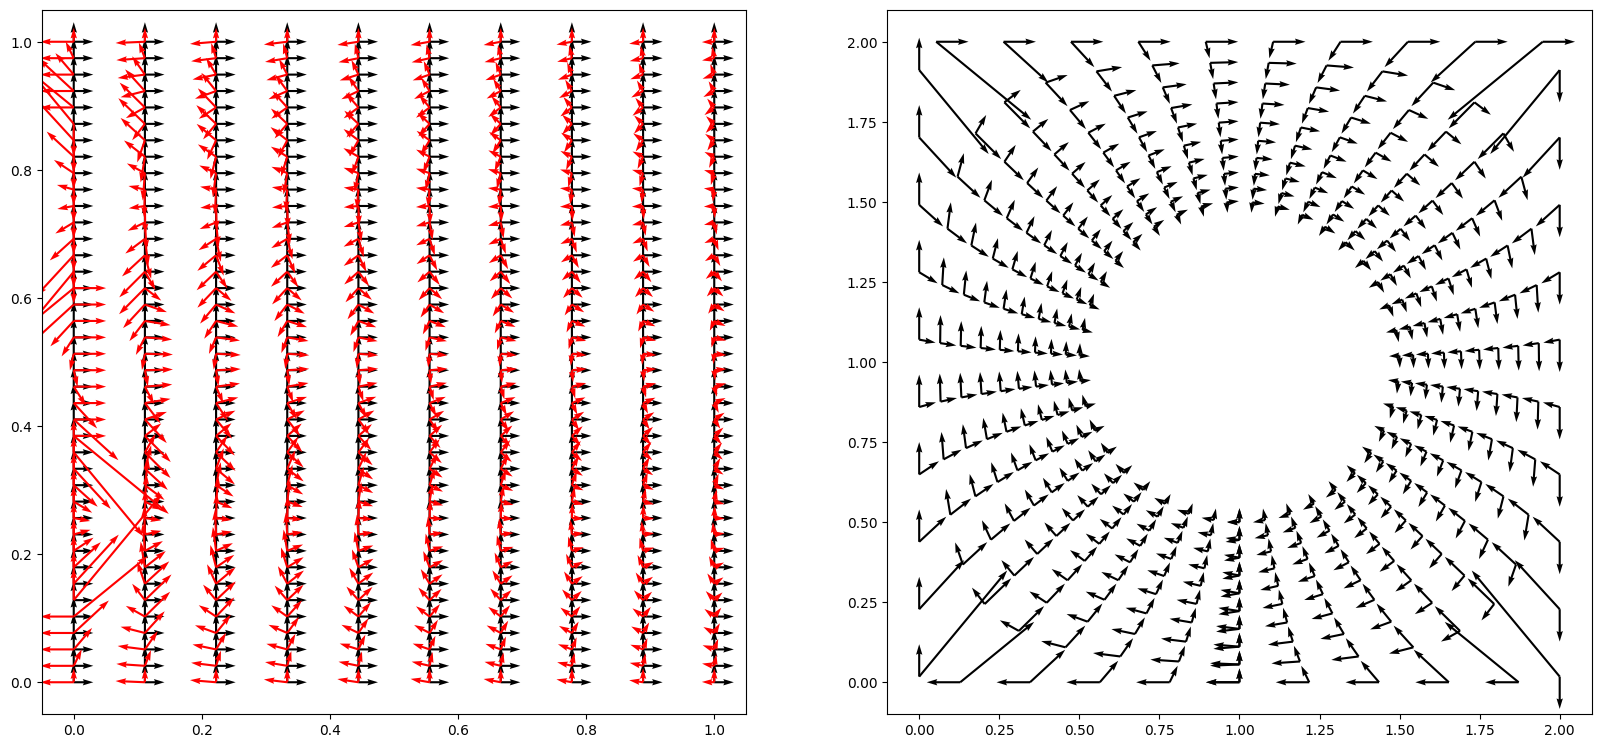

In [14]:
def coordMap(x, padding=1e-6):
    x_pos = x[0]*(nx-1)*(1-2*padding) + padding
    y_pos = x[1]*(ny-1)*(1-2*padding) + padding

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1, mode='nearest')
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1, mode='nearest')

    return jnp.stack((x_mapped, y_mapped), axis=0)

def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    return J @ tens 

vec1 = jnp.ones(X_mapped.shape)
vec0 = jnp.zeros(X_mapped.shape)

U_1 = jnp.stack((vec1, vec0), axis=1)
U_2 = jnp.stack((vec0, vec1), axis=1)

U1_mapped = jax.vmap(tensMap)(U_1, jnp.stack((X_plot, Y_plot), axis=1)).squeeze()
U2_mapped = jax.vmap(tensMap)(U_2, jnp.stack((X_plot, Y_plot), axis=1)).squeeze()

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].quiver(X_plot, Y_plot, vec1, vec0)
ax[0].quiver(X_plot, Y_plot, vec0, vec1)

ax[0].quiver(X_plot, Y_plot, U1_mapped[:, 0], U1_mapped[:, 1], color='r')
ax[0].quiver(X_plot, Y_plot, U2_mapped[:, 0], U2_mapped[:, 1], color='r')
ax[0].set_aspect('equal')
ax[1].quiver(X_mapped, Y_mapped, U1_mapped[:, 0], U1_mapped[:, 1])
ax[1].quiver(X_mapped, Y_mapped, U2_mapped[:, 0], U2_mapped[:, 1])
ax[1].set_aspect('equal')